In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize

In [3]:
PATH_RESIDENT = r"/Users/hester/Desktop/data/resident.xlsx"
UK_SHP = r"/Users/hester/Desktop/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"

In [4]:
# 读居民区点
df = pd.read_excel(PATH_RESIDENT)

lon_col, lat_col = "LONG", "LAT"

pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs="EPSG:4326")

In [5]:
world = gpd.read_file(UK_SHP)

name_fields = [c for c in ["ADMIN", "NAME", "NAME_EN", "SOVEREIGNT", "BRK_NAME"] if c in world.columns]
if not name_fields:
    raise ValueError(f"找不到国家名称字段。现有字段：{list(world.columns)}")

uk = None
for f in name_fields:
    m = world[f].astype(str).str.contains(r"United Kingdom", case=False, na=False)
    if m.any():
        uk = world.loc[m].copy()
        break

if uk is None:
    for f in name_fields:
        m = world[f].astype(str).str.contains(r"Great Britain|Northern Ireland|Britain", case=False, na=False)
        if m.any():
            uk = world.loc[m].copy()
            break

if uk is None:
    raise ValueError("在 ne_10m_admin_0_countries 里没找到 United Kingdom 记录，请检查字段/数据版本。")

uk = uk.to_crs("EPSG:4326")
uk_geom = uk.unary_union
uk_gdf = gpd.GeoDataFrame(geometry=[uk_geom], crs="EPSG:4326")

/var/folders/t7/mdmmjjzs7svdzv7rr3xllsgh0000gn/T/ipykernel_9229/4251017823.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uk_geom = uk.unary_union


In [6]:
pts_in_uk = gpd.sjoin(pts, uk_gdf, predicate="within", how="inner").drop(columns=["index_right"])

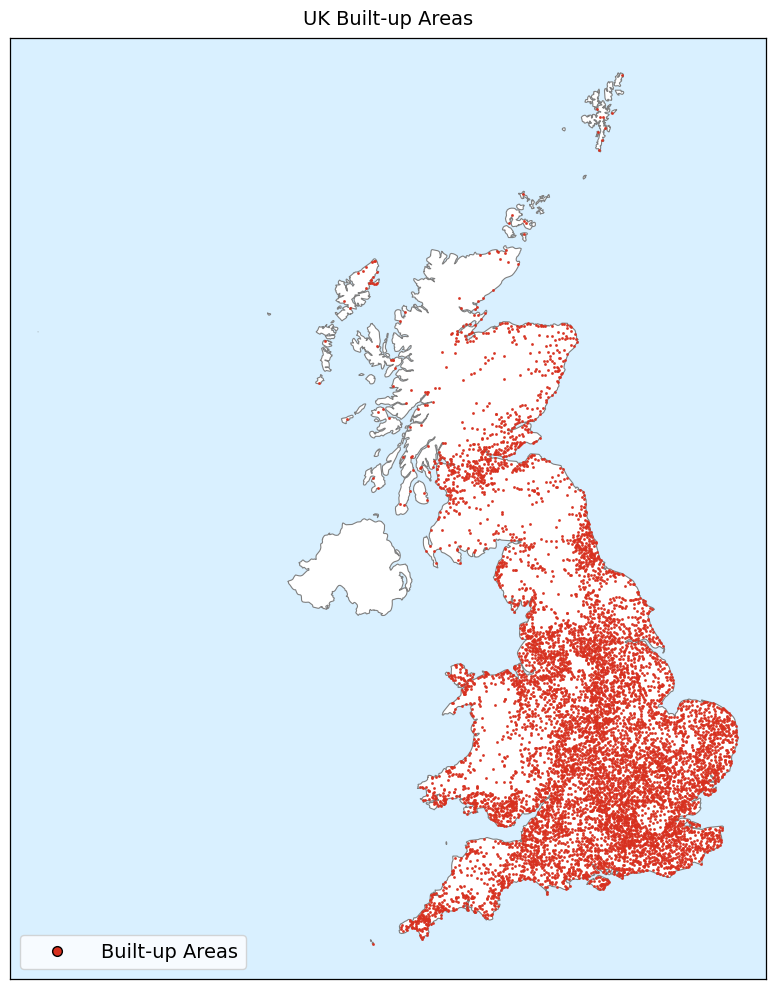

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
ax.set_facecolor("#d9f0ff")
uk.plot(ax=ax, facecolor="white", edgecolor="#7f7f7f", linewidth=0.8, zorder=2)

# 居民区点
pts_in_uk.plot(ax=ax, color="#d7301f", markersize=1.2, alpha=0.85, zorder=3)

minx, miny, maxx, maxy = uk.total_bounds
padx = (maxx - minx) * 0.04
pady = (maxy - miny) * 0.04
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)
#ax.set_aspect("equal", adjustable="box")

legend_handles = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="#d7301f",
           markersize=7, label="Built-up Areas")]

ax.legend(handles=legend_handles, loc="lower left", fontsize=14,labelspacing=1.2,handlelength=3)
ax.set_title("UK Built-up Areas", fontsize=14, pad=10)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")

plt.tight_layout()
plt.show()
fig.savefig("UK Built-up Areas.png", dpi=300, bbox_inches="tight")

In [8]:
OUT_TIF= "/Users/hester/Desktop/data/res_binary.tif"

In [9]:
lon_col, lat_col = "LONG", "LAT"

# 缓冲区半径
BUFFER_M = 1500

# 输出栅格分辨率
RES_M = 1000

df = pd.read_excel(PATH_RESIDENT)
pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs="EPSG:4326"
)

In [10]:
uk_land = gpd.GeoDataFrame(geometry=[uk.unary_union], crs="EPSG:4326")
uk_m = uk_land.to_crs("EPSG:27700")
pts_m = pts.to_crs("EPSG:27700")

pts_m = gpd.sjoin(pts_m, uk_m, predicate="within", how="inner").drop(columns=["index_right"])

buf_union = pts_m.buffer(BUFFER_M).unary_union

/var/folders/t7/mdmmjjzs7svdzv7rr3xllsgh0000gn/T/ipykernel_9229/346592959.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  uk_land = gpd.GeoDataFrame(geometry=[uk.unary_union], crs="EPSG:4326")
/var/folders/t7/mdmmjjzs7svdzv7rr3xllsgh0000gn/T/ipykernel_9229/346592959.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = pts_m.buffer(BUFFER_M).unary_union


In [11]:

minx, miny, maxx, maxy = uk_m.total_bounds
pad = 30000
minx -= pad; miny -= pad; maxx += pad; maxy += pad

width = int(np.ceil((maxx - minx) / RES_M))
height = int(np.ceil((maxy - miny) / RES_M))

transform = from_origin(minx, maxy, RES_M, RES_M)

In [12]:
suit = np.ones((height, width), dtype=np.uint8)

buf_ras = rasterize(
    [(buf_union, 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)

suit[buf_ras == 1] = 0

In [13]:
land_mask = rasterize(
    [(uk_m.geometry.iloc[0], 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)

nodata = 255 
suit_masked = suit.copy()
suit_masked[land_mask == 0] = nodata

In [14]:
os.makedirs(os.path.dirname(OUT_TIF), exist_ok=True)

with rasterio.open(
    OUT_TIF,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=rasterio.uint8,
    crs="EPSG:27700",
    transform=transform,
    nodata=nodata,
    compress="lzw"
) as dst:
    dst.write(suit_masked, 1)
print("Saved:", OUT_TIF)

Saved: /Users/hester/Desktop/data/res_binary.tif


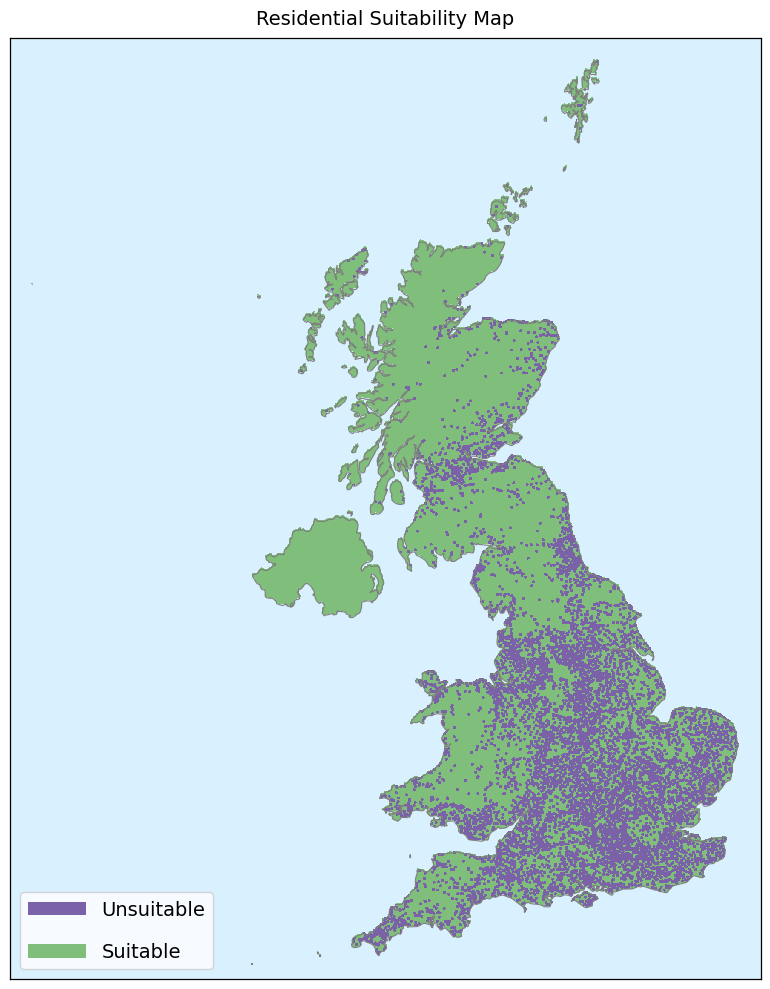

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
ax.set_facecolor("#d9f0ff")
uk_gdf.plot(ax=ax, facecolor="white", edgecolor="#7f7f7f", linewidth=0.8, zorder=2)

show = suit_masked.astype("float32")
show[show == nodata] = np.nan

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#7b61a8", "#7fbf7b" ])

extent = (minx, minx + width * RES_M, miny, miny + height * RES_M)

ax.imshow(
    show,
    extent=extent,
    origin="upper",
    interpolation="nearest",
    cmap=cmap,
    vmin=0,
    vmax=1,
    zorder=2)

uk_m.boundary.plot(ax=ax, edgecolor="#7f7f7f", linewidth=0.8, zorder=3)

ax.set_title("Residential Suitability Map", fontsize=14, pad=10)

legend_elements = [
    Patch(facecolor="#7b61a8", edgecolor="none", label="Unsuitable"),
    Patch(facecolor="#7fbf7b", edgecolor="none", label="Suitable")
]
ax.legend(handles=legend_elements, loc="lower left",fontsize=14,labelspacing=1.2,handlelength=3)
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(0.9)
    spine.set_edgecolor("black")
plt.tight_layout()
plt.show()
fig.savefig("Residential Suitability Map.png", dpi=300, bbox_inches="tight")